### Imports

In [1]:
import numpy as np
from scipy.optimize import linear_sum_assignment
from nltk.metrics import edit_distance
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer
import string, re
from collections import defaultdict
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from warnings import filterwarnings
filterwarnings("ignore")

/usr/local/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Definition

In [2]:
class CharacterChannelEmbedding:
    def __init__(self, use_ngrams=True, n=3, position_encoding="relative", use_weights=True, qwerty_thres_distance=2):
        self.num_channels = 9
        self.use_ngrams = use_ngrams
        self.n = n
        self.position_encoding = position_encoding
        self.use_weights = use_weights
        self.qwerty_thres_distance = qwerty_thres_distance
        self.embedding_cache = {}

        self.qwerty_layout = {
            '1': (0, 0), '2': (1, 0), '3': (2, 0), '4': (3, 0), '5': (4, 0),
            '6': (5, 0), '7': (6, 0), '8': (7, 0), '9': (8, 0), '0': (9, 0),

            'q': (0, 1), 'w': (1, 1), 'e': (2, 1), 'r': (3, 1), 't': (4, 1),
            'y': (5, 1), 'u': (6, 1), 'i': (7, 1), 'o': (8, 1), 'p': (9, 1),

            'a': (0, 2), 's': (1, 2), 'd': (2, 2), 'f': (3, 2), 'g': (4, 2),
            'h': (5, 2), 'j': (6, 2), 'k': (7, 2), 'l': (8, 2),

            'z': (0, 3), 'x': (1, 3), 'c': (2, 3), 'v': (3, 3), 'b': (4, 3),
            'n': (5, 3), 'm': (6, 3),

            ' ': (4.5, 4)
        }

        for key, pos in list(self.qwerty_layout.items()):
            if key.isalpha():
                self.qwerty_layout[key.upper()] = pos

        if self.use_weights:
            self.channel_weights = np.array([
                1.0,  # frequency
                0.8,  # case
                0.9,  # position
                0.7,  # char type
                0.6,  # word boundary density
                0.8,  # local context
                0.5,  # phonetic
                0.7,  # qwerty x coord
                0.7,  # qwerty y coord
            ])
        else:
            self.channel_weights = np.ones(self.num_channels)

    def get_qwerty_position(self, char: str):
        assert len(char) <= 1
        return self.qwerty_layout.get(char.lower(), (5.0, 2.5))

    def calculate_qwerty_distance(self, char1: str, char2: str):
        pos1 = self.get_qwerty_position(char1)
        pos2 = self.get_qwerty_position(char2)
        return np.sqrt((pos1[0] - pos2[0])**2 + (pos1[1] - pos2[1])**2)

    def get_character_type(self, char: str):
        assert len(char) <= 1
        if char.isalpha():
            return 1.0 if char.isupper() else 0.8
        elif char.isdigit():
            return 0.6
        elif char in string.punctuation:
            return 0.4
        elif char.isspace():
            return 0.2
        else:
            return 0.0

    def get_phonetic_features(self, char: str):
        assert len(char) <= 1
        vowels = "aeiouAEIOU"
        consonants = "bcdfghjklmnpqrstvwxyzBCDFGHJKLMNPQRSTVWXYZ"
        if char in vowels:
            return 1.0
        elif char in consonants:
            return 0.0
        else:
            return 0.5

    def encode_position(self, positions, text_length):
        if not positions:
            return 0.0
        avg_pos = sum(positions) / len(positions)
        if self.position_encoding == "relative":
            return avg_pos / max(text_length - 1, 1)
        elif self.position_encoding == "absolute":
            return float(avg_pos)
        elif self.position_encoding == "sinusoidal":
            normalized_pos = avg_pos / max(text_length - 1, 1)
            return float(np.sin(2 * np.pi * normalized_pos))
        else:
            return float(avg_pos)

    def _utf8_bytes_to_scalar(self, b: bytes, method='mean'):
        if not b:
            return 0.0
        if method == 'first':
            return float(b[0]) / 255.0
        elif method == 'mean':
            return float(sum(b)) / (len(b) * 255.0)
        elif method == 'int_norm':
            val = int.from_bytes(b, byteorder='big', signed=False)
            denom = (256 ** len(b)) - 1
            return float(val) / denom if denom > 0 else 0.0
        else:
            return float(sum(b)) / (len(b) * 255.0)

    def extract_ngrams(self, text: str):
        ngrams = {}
        L = len(text)
        for i in range(max(0, L - self.n + 1)):
            ngram_str = text[i:i + self.n]
            ngram_key = ngram_str.encode("utf-8")

            if ngram_key not in ngrams:
                ngrams[ngram_key] = [0.0] * self.num_channels

            ngrams[ngram_key][0] += 1.0
            ngrams[ngram_key][2] = i / max(L - 1, 1)
        return ngrams

    def create_embedding(self, text: str):
        if text in self.embedding_cache:
            return self.embedding_cache[text]

        text_clean = text
        text_length = len(text_clean)

        raw = {}

        words = re.findall(r"\S+", text_clean)
        word_boundary_positions = set()
        current = 0
        for w in words:
            start = text_clean.find(w, current)
            if start == -1:
                continue
            end = start + len(w) - 1
            word_boundary_positions.update([start, end])
            current = end + 1

        for pos, ch in enumerate(text_clean):
            token_key = ch.encode("utf-8")

            if token_key not in raw:
                raw[token_key] = {
                    "frequency": 0,
                    "case_sum": 0.0,
                    "positions": [],
                    "char_type_sum": 0.0,
                    "boundary_count": 0,
                    "local_context": [],
                    "phonetic_sum": 0.0,
                    "qwerty_x_sum": 0.0,
                    "qwerty_y_sum": 0.0,
                }

            entry = raw[token_key]
            entry["frequency"] += 1
            entry["case_sum"] += float(ch.isupper())
            entry["positions"].append(pos)
            entry["char_type_sum"] += self.get_character_type(ch)
            if pos in word_boundary_positions:
                entry["boundary_count"] += 1

            for offset in (-1, 1):
                p = pos + offset
                if 0 <= p < text_length:
                    neighbor_token = text_clean[p].encode("utf-8")

                    entry["local_context"].append(self._utf8_bytes_to_scalar(neighbor_token, method='mean'))

            entry["phonetic_sum"] += self.get_phonetic_features(ch)

            qwerty_pos = self.get_qwerty_position(ch)
            entry["qwerty_x_sum"] += qwerty_pos[0]
            entry["qwerty_y_sum"] += qwerty_pos[1]

        final_embedding = {}
        for token_key, feats in raw.items():
            freq = feats["frequency"]
            vec = [
                float(freq),
                feats["case_sum"] / freq if freq else 0.0,
                float(self.encode_position(feats["positions"], text_length)),
                feats["char_type_sum"] / freq if freq else 0.0,
                feats["boundary_count"] / freq if freq else 0.0,
                float(np.mean(feats["local_context"])) if feats["local_context"] else 0.0,
                feats["phonetic_sum"] / freq if freq else 0.0,
                feats["qwerty_x_sum"] / freq if freq else 0.0,
                feats["qwerty_y_sum"] / freq if freq else 0.0,
            ]
            final_embedding[token_key] = vec

        if self.use_ngrams and len(text_clean) >= self.n:
            ngram_feats = self.extract_ngrams(text_clean)
            for k, v in ngram_feats.items():
                if len(v) < self.num_channels:
                    v = v + [0.0] * (self.num_channels - len(v))
                final_embedding[k] = v

        keys = list(final_embedding.keys())
        mat = np.array([final_embedding[k] for k in keys], dtype=float)

        col_norms = np.linalg.norm(mat, axis=0)
        col_norms = np.where(col_norms == 0.0, 1.0, col_norms)

        mat_norm = mat / col_norms

        for i, k in enumerate(keys):
            final_embedding[k] = mat_norm[i].tolist()

        self.embedding_cache[text] = final_embedding
        return final_embedding

    def _get_key_similarity_weight(self, key1, key2):
        try:
            s1 = key1.decode('utf-8')
            s2 = key2.decode('utf-8')
        except:
            return 0.0

        if len(s1) != len(s2):
            return 0.0

        dists = []
        for c1, c2 in zip(s1, s2):
            dists.append(self.calculate_qwerty_distance(c1, c2))

        if not dists:
            return 0.0

        mean_dist = np.mean(dists)
        if mean_dist <= self.qwerty_thres_distance:
            return 1 - mean_dist / self.qwerty_thres_distance
        else:
            return 0.0

    def calculate_similarity(self, text1: str, text2: str):
        embed1 = self.create_embedding(text1)
        embed2 = self.create_embedding(text2)

        keys1 = list(embed1.keys())
        keys2 = list(embed2.keys())
        if not keys1 or not keys2:
            return 0.0

        num1 = len(keys1)
        num2 = len(keys2)

        sim_matrix = np.zeros((num1, num2))

        for i, k1 in enumerate(keys1):
            v1 = np.array(embed1[k1], dtype=float)
            if self.use_weights:
                v1 = v1 * self.channel_weights

            for j, k2 in enumerate(keys2):
                v2 = np.array(embed2[k2], dtype=float)
                if self.use_weights:
                    v2 = v2 * self.channel_weights

                dot = np.dot(v1, v2)
                weight = self._get_key_similarity_weight(k1, k2)
                sim_matrix[i, j] = dot * weight

        cost = -sim_matrix
        row_ind, col_ind = linear_sum_assignment(cost)
        matched_dot = sum(sim_matrix[row, col] for row, col in zip(row_ind, col_ind))

        norm1_sq = 0.0
        for k1 in keys1:
            v1 = np.array(embed1[k1], dtype=float)
            if self.use_weights:
                v1 = v1 * self.channel_weights
            norm1_sq += np.dot(v1, v1)
        norm1 = np.sqrt(norm1_sq)

        norm2_sq = 0.0
        for k2 in keys2:
            v2 = np.array(embed2[k2], dtype=float)
            if self.use_weights:
                v2 = v2 * self.channel_weights
            norm2_sq += np.dot(v2, v2)
        norm2 = np.sqrt(norm2_sq)

        if norm1 == 0 or norm2 == 0:
            return 0.0

        channel_sim = matched_dot / (norm1 * norm2)

        lev_dist = edit_distance(text1, text2)
        max_len = max(len(text1), len(text2))
        lev_sim = 1 - (lev_dist / max_len) if max_len > 0 else 1.0

        final_sim = 0.85 * channel_sim + 0.15 * lev_sim
        return float(final_sim)

    def search(self, query, documents, top_k=5):
        similarities = []
        for doc in documents:
            sim = self.calculate_similarity(query, doc)
            similarities.append((doc, sim))
        similarities.sort(key=lambda x: x[1], reverse=True)
        return similarities[:top_k]

    def visualize_embedding(self, text, title="Character Channel Embedding"):
        embedding = self.create_embedding(text)
        if not embedding:
            return

        token_items = [(k, v) for k, v in embedding.items() if isinstance(k, (bytes, bytearray))]
        if not token_items:
            return

        token_items.sort(key=lambda kv: kv[0])

        labels = []
        mats = []
        for key_bytes, vec in token_items:
            try:
                label = key_bytes.decode("utf-8", errors="replace")
            except Exception:
                label = repr(key_bytes)
            labels.append(label)
            mats.append(vec)

        mat = np.array(mats)
        channel_labels = [
            "Frequency", "Case (0=Lower,1=Upper)", "Position",
            "CharType", "WordBoundary", "LocalContext", "Phonetic", "QWERTY-X", "QWERTY-Y"
        ]
        if mat.shape[1] < len(channel_labels):
            channel_labels = channel_labels[:mat.shape[1]]

        plt.figure(figsize=(12, max(len(labels) * 0.3, 4)))
        sns.heatmap(mat, xticklabels=channel_labels, yticklabels=labels, annot=True, fmt=".2f", cmap="viridis")
        plt.title(f"{title}: \"{text}\"")
        plt.tight_layout()
        plt.show()

    def get_embedding_stats(self, text):
        embedding = self.create_embedding(text)
        stats = {
            "num_unique_tokens": len(embedding),
            "total_channels": self.num_channels,
            "avg_frequency": np.mean([vals[0] for vals in embedding.values()]) if embedding else 0.0,
            "token_distribution": {}
        }
        for token_bytes, vals in embedding.items():
            label = token_bytes.decode("utf-8", errors="replace") if isinstance(token_bytes, (bytes, bytearray)) else str(token_bytes)
            stats["token_distribution"][label] = {
                "frequency": vals[0],
                "avg_position": vals[2] if len(vals) > 2 else None,
                "char_type": vals[3] if len(vals) > 3 else None
            }
        return stats

    class TextCNN(nn.Module):
        def __init__(self, num_channels, kernel_sizes=[3, 5], num_filters=64):
            super().__init__()
            self.convs = nn.ModuleList([
                nn.Conv1d(num_channels, num_filters, k) for k in kernel_sizes
            ])
            self.acti = nn.PReLU()
            self.pool = nn.AdaptiveMaxPool1d(1)

        def forward(self, x):
            conv_outputs = [self.pool(self.acti(conv(x))).squeeze(-1) for conv in self.convs]
            return torch.cat(conv_outputs, dim=1)

    def embedding_to_tensor(self, text, max_tokens=64):
        embedding = self.create_embedding(text)
        keys = sorted(embedding.keys())
        matrix = np.array([embedding[k] for k in keys], dtype=np.float32)
        if len(keys) < max_tokens:
            padding = np.zeros((max_tokens - len(keys), self.num_channels), dtype=np.float32)
            matrix = np.vstack([matrix, padding])
        elif len(keys) > max_tokens:
            matrix = matrix[:max_tokens]
        return torch.tensor(matrix).transpose(0, 1).unsqueeze(0)

    def cnn_search(self, query, documents, top_k=5, model_path=None):
        cnn_model = self.TextCNN(num_channels=self.num_channels).eval()
        if model_path:
            cnn_model.load_state_dict(torch.load(model_path))
        query_tensor = self.embedding_to_tensor(query)
        with torch.no_grad():
            query_vec = cnn_model(query_tensor).squeeze(0)
        
        similarities = []
        for doc in documents:
            doc_tensor = self.embedding_to_tensor(doc)
            with torch.no_grad():
                doc_vec = cnn_model(doc_tensor).squeeze(0)
            sim = torch.cosine_similarity(query_vec, doc_vec, dim=0).item()
            similarities.append((doc, sim))
        
        similarities.sort(key=lambda x: x[1], reverse=True)
        return similarities[:top_k]

    def cnn_similarity(self, text1, text2, model_path=None):
        cnn_model = self.TextCNN(num_channels=self.num_channels).eval()
        if model_path:
            cnn_model.load_state_dict(torch.load(model_path))
        tensor1 = self.embedding_to_tensor(text1)
        tensor2 = self.embedding_to_tensor(text2)
        with torch.no_grad():
            vec1 = cnn_model(tensor1).squeeze(0)
            vec2 = cnn_model(tensor2).squeeze(0)
        return torch.cosine_similarity(vec1, vec2, dim=0).item()

    def train_cnn_similarity(self, df=None, epochs=10, learning_rate=0.001, save_path="cnn_model.pth"):
        cnn_model = self.TextCNN(num_channels=self.num_channels)
        optimizer = optim.Adam(cnn_model.parameters(), lr=learning_rate)
        criterion = nn.MSELoss()
        
        if df is not None:
            for epoch in range(epochs):
                total_loss = 0
                for _, row in df.iterrows():
                    text1, text2, target_sim = row['text1'], row['text2'], row['similarity']
                    tensor1 = self.embedding_to_tensor(text1)
                    tensor2 = self.embedding_to_tensor(text2)
                    optimizer.zero_grad()
                    vec1 = cnn_model(tensor1).squeeze(0)
                    vec2 = cnn_model(tensor2).squeeze(0)
                    pred_sim = torch.cosine_similarity(vec1, vec2, dim=0)
                    loss = criterion(pred_sim, torch.tensor(target_sim, dtype=torch.float32))
                    loss.backward()
                    optimizer.step()
                    total_loss += loss.item()
                print(f"Epoch {epoch+1}, Loss: {total_loss / len(df):.4f}")
        else:
            pairs = [
                ("cat", "bat", 0.9), ("cat", "dog", 0.3),
                ("hello", "jello", 0.8), ("hello", "world", 0.2),
                ("quick", "quack", 0.7), ("test", "testing", 0.85)
            ]
            for epoch in range(epochs):
                total_loss = 0
                for text1, text2, target_sim in pairs:
                    tensor1 = self.embedding_to_tensor(text1)
                    tensor2 = self.embedding_to_tensor(text2)
                    optimizer.zero_grad()
                    vec1 = cnn_model(tensor1).squeeze(0)
                    vec2 = cnn_model(tensor2).squeeze(0)
                    pred_sim = torch.cosine_similarity(vec1, vec2, dim=0)
                    loss = criterion(pred_sim, torch.tensor(target_sim, dtype=torch.float32))
                    loss.backward()
                    optimizer.step()
                    total_loss += loss.item()
                print(f"Epoch {epoch+1}, Loss: {total_loss / len(pairs):.4f}")
        
        torch.save(cnn_model.state_dict(), save_path)
        return cnn_model

    def cnn_reduce_dimensionality(self, texts, target_dim=2, model_path=None):
        cnn_model = self.TextCNN(num_channels=self.num_channels).eval()
        if model_path:
            cnn_model.load_state_dict(torch.load(model_path))
        vectors = []
        for text in texts:
            tensor = self.embedding_to_tensor(text)
            with torch.no_grad():
                vec = cnn_model(tensor).squeeze(0).numpy()
            vectors.append(vec)
        vectors = np.array(vectors)
        pca = PCA(n_components=target_dim)
        reduced = pca.fit_transform(vectors)
        return reduced, pca.explained_variance_ratio_

In [3]:
def compare_embeddings():
    char_embed = CharacterChannelEmbedding()

    try:
        sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
        use_sentence_transformer = True
    except:
        print("Warning: SentenceTransformer not available. Skipping ST comparison.")
        use_sentence_transformer = False

    documents = [
        "The quick brown fox jumps over the lazy dog",
        "A fast brown fox leaps above a sleepy canine", 
        "The slow red cat walks under the energetic bird",
        "Quick brown foxes jump over lazy dogs",
        "Python is a programming language",
        "Java is also a programming language",
        "Machine learning models require data",
        "Data science involves statistical analysis"
    ]
    
    query = "brown fox jumps"
    
    print(f"Query: \"{query}\"")
    print("\n" + "="*60)

    char_similarities = []
    for doc in documents:
        sim = char_embed.calculate_similarity(query, doc)
        char_similarities.append((doc, sim))
    
    print("\nCharacter Channel Embedding Results (in input order):")
    print("-" * 40)
    for i, (doc, score) in enumerate(char_similarities):
        print(f"{i+1}. (Score: {score:.4f}) {doc}")
    
    if use_sentence_transformer:
        query_st_embed = sentence_model.encode([query])
        doc_st_embeds = sentence_model.encode(documents)
        st_similarities = cosine_similarity(query_st_embed, doc_st_embeds)[0]

        st_results = [(doc, sim) for doc, sim in zip(documents, st_similarities)]
        
        print("\nSentence Transformer Results (in input order):")
        print("-" * 40)
        for i, (doc, score) in enumerate(st_results):
            print(f"{i+1}. (Score: {score:.4f}) {doc}")
    
    return char_embed, char_similarities

def visualize_embedding_space():
    char_embed = CharacterChannelEmbedding()

    words = [
        "cat", "bat", "hat", "rat",
        "dog", "log", "fog", "hog",
        "run", "gun", "sun", "fun",
        "tree", "free", "three",
        "apple", "grape", "orange",
        "quick", "brown", "jumps"
        "crack", "lack",
        "dice", "mice",
        "chopper", "chauffer",
        "chopper", "hopper",
        "chopper", "copper",
    ]

    all_char_codes = set()
    embeddings_dict = {}

    for word in words:
        embed = char_embed.create_embedding(word)
        embeddings_dict[word] = embed
        all_char_codes.update(embed.keys())

    sorted_char_codes = sorted(all_char_codes)

    embeddings = []
    labels = []

    for word in words:
        embed = embeddings_dict[word]
        vec = np.concatenate([np.array(embed.get(k, [0.0] * char_embed.num_channels), dtype=float) for k in sorted_char_codes])
        embeddings.append(vec)
        labels.append(word)

    embeddings_array = np.array(embeddings)
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(embeddings_array)

    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], s=100, alpha=0.7, c=range(len(words)), cmap="tab20")

    for i, word in enumerate(words):
        plt.annotate(word, (embeddings_2d[i, 0], embeddings_2d[i, 1]), xytext=(5, 5), textcoords="offset points", fontsize=10)

    plt.title("Character Channel Embedding Space (PCA Projection)")
    plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)")
    plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    print(f"PCA Explained Variance: PC1={pca.explained_variance_ratio_[0]:.1%}, PC2={pca.explained_variance_ratio_[1]:.1%}")

### Similarity

In [4]:
char_embed, results = compare_embeddings()

Query: "brown fox jumps"


Character Channel Embedding Results (in input order):
----------------------------------------
1. (Score: 0.5630) The quick brown fox jumps over the lazy dog
2. (Score: 0.5019) A fast brown fox leaps above a sleepy canine
3. (Score: 0.4212) The slow red cat walks under the energetic bird
4. (Score: 0.5866) Quick brown foxes jump over lazy dogs
5. (Score: 0.4718) Python is a programming language
6. (Score: 0.5062) Java is also a programming language
7. (Score: 0.4423) Machine learning models require data
8. (Score: 0.3848) Data science involves statistical analysis

Sentence Transformer Results (in input order):
----------------------------------------
1. (Score: 0.7794) The quick brown fox jumps over the lazy dog
2. (Score: 0.7432) A fast brown fox leaps above a sleepy canine
3. (Score: 0.2715) The slow red cat walks under the energetic bird
4. (Score: 0.7607) Quick brown foxes jump over lazy dogs
5. (Score: 0.0792) Python is a programming language
6. (Score:

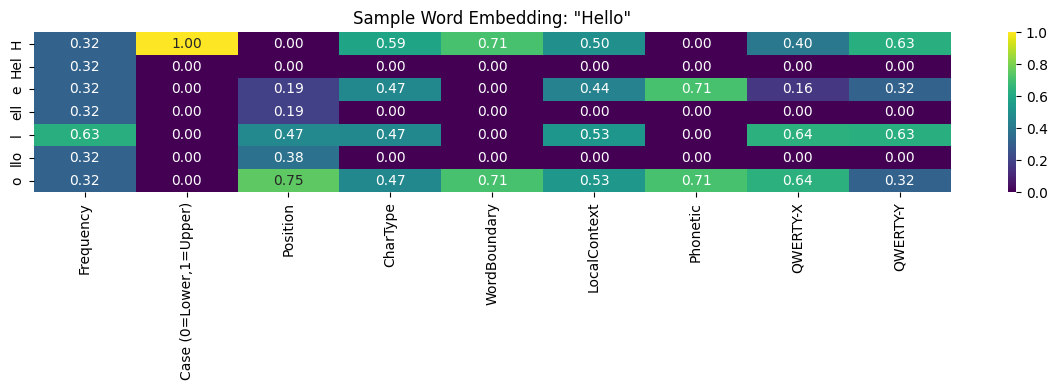

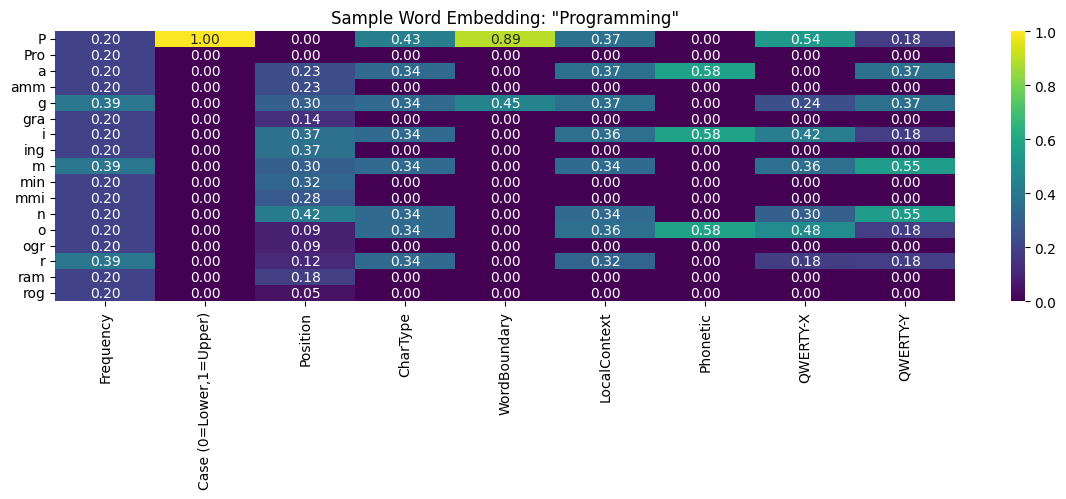

In [5]:
char_embed.visualize_embedding("Hello", "Sample Word Embedding")
char_embed.visualize_embedding("Programming", "Sample Word Embedding")

### Vis

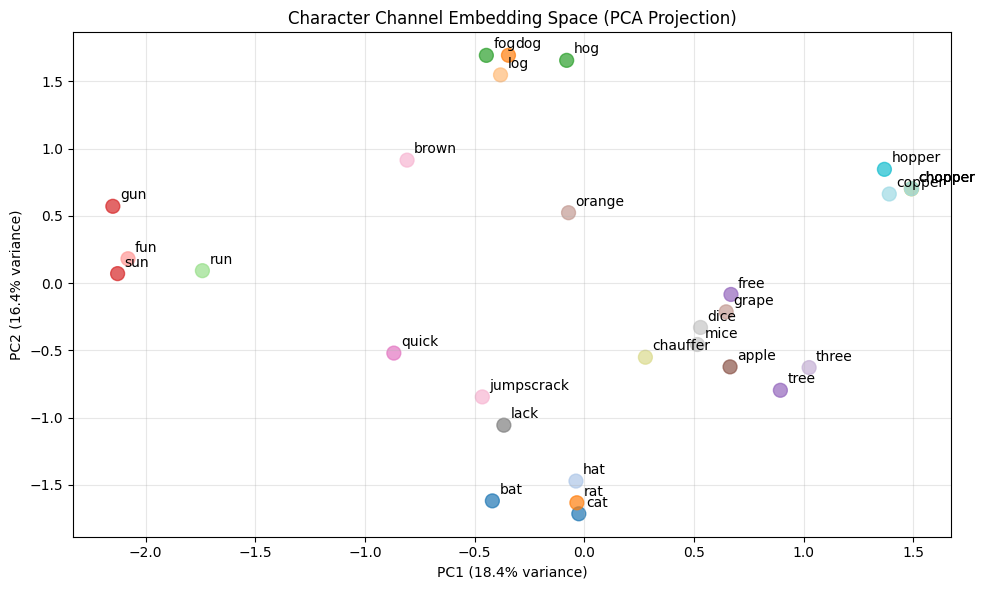

PCA Explained Variance: PC1=18.4%, PC2=16.4%


In [6]:
visualize_embedding_space()

In [7]:
similarity_tests = [
    ("cat", "bat"),
    ("programming", "Programming"), 
    ("hello", "world"),
    ("quick", "quack"),
    ("test", "testing"),
    ("crack", "lack"),
    ("dice", "mice"),
    ("chopper", "chauffer"),
    ("chopper", "hopper"),
    ("chopper", "copper"),
    ("hello","jello"),
]

for word1, word2 in similarity_tests:
    sim = char_embed.calculate_similarity(word1, word2)
    print(f"Similarity(\"{word1}\", \"{word2}\"): {sim:.4f}")

Similarity("cat", "bat"): 0.6929
Similarity("programming", "Programming"): 0.9317
Similarity("hello", "world"): 0.4609
Similarity("quick", "quack"): 0.7399
Similarity("test", "testing"): 0.5726
Similarity("crack", "lack"): 0.7436
Similarity("dice", "mice"): 0.7654
Similarity("chopper", "chauffer"): 0.5232
Similarity("chopper", "hopper"): 0.8806
Similarity("chopper", "copper"): 0.9185
Similarity("hello", "jello"): 0.8883


---

### CNN ops

In [8]:
embedder = CharacterChannelEmbedding(use_ngrams=True, n=3)

#### Dim reduction


=== CNN-Based Dimensionality Reduction ===


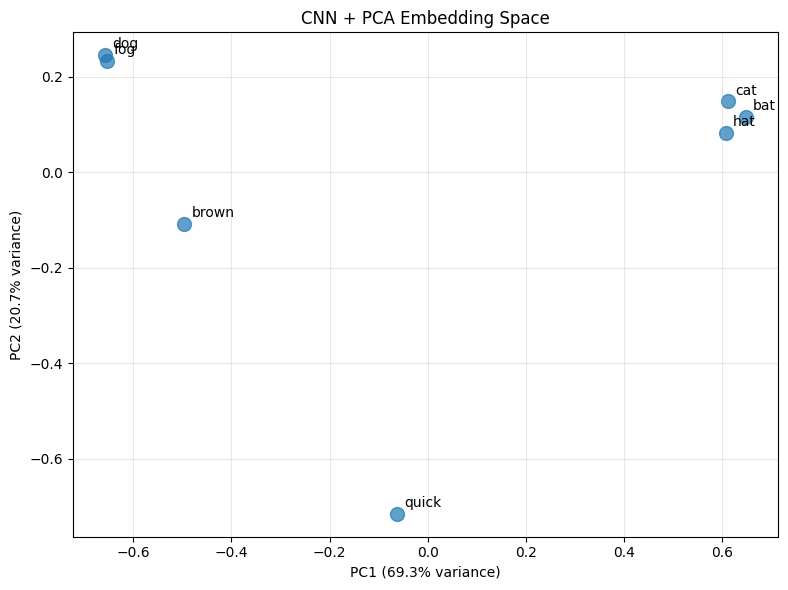

PCA Explained Variance: PC1=69.3%, PC2=20.7%


In [9]:
print("\n=== CNN-Based Dimensionality Reduction ===")
words = ["cat", "bat", "hat", "dog", "fog", "quick", "brown"]
reduced, variance = embedder.cnn_reduce_dimensionality(words, target_dim=2)
plt.figure(figsize=(8, 6))
plt.scatter(reduced[:, 0], reduced[:, 1], s=100, alpha=0.7)
for i, word in enumerate(words):
    plt.annotate(word, (reduced[i, 0], reduced[i, 1]), xytext=(5, 5), textcoords="offset points")
plt.title("CNN + PCA Embedding Space")
plt.xlabel(f"PC1 ({variance[0]:.1%} variance)")
plt.ylabel(f"PC2 ({variance[1]:.1%} variance)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"PCA Explained Variance: PC1={variance[0]:.1%}, PC2={variance[1]:.1%}")

#### Search

In [10]:
print("\n=== CNN-Based Search ===")
query = "brown fox jumps"
documents = [
    "The quick brown fox jumps over the lazy dog",
    "A fast brown fox leaps above a sleepy canine",
    "The slow red cat walks under the energetic bird",
    "Quick brown foxes jump over lazy dogs",
    "Python is a programming language"
]
results = embedder.cnn_search(query, documents, top_k=3)
for i, (doc, score) in enumerate(results, 1):
    print(f"{i}. Score: {score:.4f}, Doc: {doc}")


=== CNN-Based Search ===
1. Score: 0.9648, Doc: Quick brown foxes jump over lazy dogs
2. Score: 0.9633, Doc: The quick brown fox jumps over the lazy dog
3. Score: 0.9627, Doc: Python is a programming language


#### Similarity

In [11]:
print("=== Training CNN (Supervised) ===")
df = pd.DataFrame({
    'text1': ['cat', 'hello', 'quick', 'test', 'chopper'],
    'text2': ['bat', 'jello', 'quack', 'testing', 'hopper'],
    'similarity': [0.9, 0.8, 0.7, 0.85, 0.75]
})
cnn_model = embedder.train_cnn_similarity(df=df, epochs=5)

=== Training CNN (Supervised) ===
Epoch 1, Loss: 0.0376
Epoch 2, Loss: 0.0356
Epoch 3, Loss: 0.0333
Epoch 4, Loss: 0.0309
Epoch 5, Loss: 0.0284


In [ ]:
print("\n=== CNN-Based Similarity ===")
similarity_tests = [
    ("cat", "bat"),
    ("hello", "jello"),
    ("quick", "quack"),
    ("test", "testing"),
    ("chopper", "hopper"),
    ("dog", "dogg"),
    ("programming", "programing"),
    ("youtube", "youtub"),
    ("machine learning", "AI learning"),
    ("fast car", "quick vehicle"),
    ("apple", "aple"),
    ("search engine", "search motor"),
    ("the quick fox", "quick fox"),
    ("data science", "data analysis"),
    ("python code", "python script")
]
for text1, text2 in similarity_tests:
    sim = embedder.cnn_similarity(text1, text2)
    print(f"CNN Similarity('{text1}', '{text2}'): {sim:.4f}")


=== CNN-Based Similarity ===
CNN Similarity('cat', 'bat'): 0.9961
CNN Similarity('hello', 'jello'): 0.9999
CNN Similarity('quick', 'quack'): 0.9678
CNN Similarity('test', 'testing'): 0.9418
CNN Similarity('chopper', 'hopper'): 0.9880
CNN Similarity('dog', 'dogg'): 0.9828
CNN Similarity('programming', 'programing'): 0.9950
CNN Similarity('youtube', 'youtub'): 0.9762
CNN Similarity('machine learning', 'AI learning'): 0.9691
CNN Similarity('fast car', 'quick vehicle'): 0.9695
CNN Similarity('apple', 'aple'): 0.9965
CNN Similarity('search engine', 'search motor'): 0.9886
CNN Similarity('the quick fox', 'quick fox'): 0.9896
CNN Similarity('data science', 'data analysis'): 0.9791
CNN Similarity('python code', 'python script'): 0.9731


In [13]:
print("\n=== Training CNN (Unsupervised) ===")
embedder.train_cnn_similarity(epochs=5)


=== Training CNN (Unsupervised) ===
Epoch 1, Loss: 0.1745
Epoch 2, Loss: 0.1623
Epoch 3, Loss: 0.1490
Epoch 4, Loss: 0.1348
Epoch 5, Loss: 0.1201


TextCNN(
  (convs): ModuleList(
    (0): Conv1d(9, 64, kernel_size=(3,), stride=(1,))
    (1): Conv1d(9, 64, kernel_size=(5,), stride=(1,))
  )
  (acti): PReLU(num_parameters=1)
  (pool): AdaptiveMaxPool1d(output_size=1)
)

In [ ]:
print("\n=== CNN-Based Similarity ===")
similarity_tests = [
    ("cat", "bat"),                    # Single-letter typo (QWERTY proximity)
    ("hello", "jello"),                # Typo with phonetic similarity
    ("quick", "quack"),
    ("test", "testing"),
    ("chopper", "hopper"),
    ("dog", "dogg"),
    ("programming", "programing"),
    ("youtube", "youtub"),
    ("machine learning", "AI learning"),
    ("fast car", "quick vehicle"),
    ("apple", "aple"),
    ("search engine", "search motor"),
    ("the quick fox", "quick fox"),
    ("data science", "data analysis"),
    ("python code", "python script")
]
for text1, text2 in similarity_tests:
    sim = embedder.cnn_similarity(text1, text2)
    print(f"CNN Similarity('{text1}', '{text2}'): {sim:.4f}")


=== CNN-Based Similarity ===
CNN Similarity('cat', 'bat'): 0.9960
CNN Similarity('hello', 'jello'): 0.9999
CNN Similarity('quick', 'quack'): 0.9721
CNN Similarity('test', 'testing'): 0.9294
CNN Similarity('chopper', 'hopper'): 0.9821
CNN Similarity('dog', 'dogg'): 0.9857
CNN Similarity('programming', 'programing'): 0.9924
CNN Similarity('youtube', 'youtub'): 0.9760
CNN Similarity('machine learning', 'AI learning'): 0.9680
CNN Similarity('fast car', 'quick vehicle'): 0.9684
CNN Similarity('apple', 'aple'): 0.9952
CNN Similarity('search engine', 'search motor'): 0.9858
CNN Similarity('the quick fox', 'quick fox'): 0.9913
CNN Similarity('data science', 'data analysis'): 0.9763
CNN Similarity('python code', 'python script'): 0.9776
